In [1]:
# Python packages
import warnings
warnings.simplefilter('ignore')

import scanpy as sc
import scparadise
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sc.set_figure_params(dpi = 120)

In [53]:
from main._1_PATHs.results import ResultsType
from main._1_PATHs.tools import ToolsType
from glob import glob
import pandas as pd
import os
import shutil
import time
import subprocess
from typing import Dict, List, Any


def collect_and_save_statistics(samples_parse_df: pd.DataFrame, sum_path: str, flowcell: str) -> None:
    # Define column mappings for each sequence type
    COLUMN_MAPPINGS: Dict[str, List[str]] = {
        'SC_TENX_RNA': [
            'estimated number of cells', 'mean reads per cell', 'median genes per cell',
            'number of reads', 'reads mapped confidently to genome', 'total genes detected',
            'median umi counts per cell'
        ],
        'SC_TENX_ATAC': [
            'estimated number of cells', 'mean raw read pairs per cell',
            'median high-quality fragments per cell',
            'fraction of high-quality fragments overlapping peaks',
            'sequenced read pairs', 'number of peaks'
        ],
        'SC_TENX_Visium_FFPE': [
            'number of spots under tissue', 'mean reads per spot',
            'median genes per spot', 'number of reads',
            'reads mapped confidently to probe set', 'genes detected', 'median umi counts per spot'
        ],
        'SC_SeekGene_RNA': [
            'estimated_number_of_cells', 'mean_reads_per_cell',
            'median_genes_per_cell', 'number_of_reads',
            'reads_mapped_confidently_to_genome', 'total_genes_detected', 'median_umi_counts_per_cell'
        ],
        'SC_SeekGene_FullRNA': [
            'estimated_number_of_cells', 'mean_reads_per_cell',
            'median_genes_per_cell', 'number_of_reads',
            'reads_mapped_confidently_to_genome', 'total_genes_detected','median_umi_counts_per_cell'
        ],
        'SC_SeekGene_VDJ': [
            'estimated number of cells', 'mean read pairs per cell', 'number of cells with productive v-j spanning pair', 
            'number of read pairs', 'reads mapped to any v(d)j gene', 'median tra umis per cell', 'median trb umis per cell'
        ]
    }

    def process_combined_rna_vdj(sample_dir: str, stats_row: Dict[str, Any]) -> None:
        """Process combined RNA+VDJ statistics"""
        # Process RNA statistics
        rna_stat_path = glob(f"{sample_dir}/*_summary.csv")
        if rna_stat_path and os.path.exists(rna_stat_path[0]):
            try:
                df_rna_stat = pd.read_csv(rna_stat_path[0])
                df_rna_stat.columns =   [x.lower() for x in df_rna_stat.columns]
                if not df_rna_stat.empty:
                    for col in COLUMN_MAPPINGS['SC_SeekGene_RNA']:
                        stats_row[f"RNA_{col}"] = df_rna_stat[col].iloc[0] if col in df_rna_stat.columns else 'N/A'
            except Exception as e:
                print(f"❌ Error reading RNA stats: {e}")
                for col in COLUMN_MAPPINGS['SC_SeekGene_RNA']:
                    stats_row[f"RNA_{col}"] = 'ERROR'

        # Process VDJ statistics
        vdj_stat_path = glob(f"{sample_dir}/outs/metrics_summary.csv")
        if vdj_stat_path and os.path.exists(vdj_stat_path[0]):
            try:
                df_vdj_stat = pd.read_csv(vdj_stat_path[0])
                df_vdj_stat.columns =   [x.lower() for x in df_vdj_stat.columns]
                if not df_vdj_stat.empty:
                    for col in COLUMN_MAPPINGS['SC_SeekGene_VDJ']:
                        stats_row[f"VDJ_{col}"] = df_vdj_stat[col].iloc[0] if col in df_vdj_stat.columns else 'N/A'
            except Exception as e:
                print(f"❌ Error reading VDJ stats: {e}")
                for col in COLUMN_MAPPINGS['SC_SeekGene_VDJ']:
                    stats_row[f"VDJ_{col}"] = 'ERROR'

    def process_single_stat_file(stat_path: str, seq_type: str, stats_row: Dict[str, Any]) -> None:
        """Process single statistics file"""
        try:
            if not os.path.exists(stat_path):
                raise FileNotFoundError(f"Statistics file not found: {stat_path}")
            
            df_stat = pd.read_csv(stat_path)
            df_stat.columns =   [x.lower() for x in df_stat.columns]
            if df_stat.empty:
                return
            columns = COLUMN_MAPPINGS.get(seq_type, [])

            for col in columns:
                stats_row[col] = df_stat[col].iloc[0] if col in df_stat.columns else 'N/A'
                
        except Exception as e:
            print(f"❌ Error processing stat file {stat_path}: {e}")
            for col in COLUMN_MAPPINGS.get(seq_type, []):
                stats_row[col] = 'ERROR'

    all_stats = []
    processed_count = 0
    error_count = 0

    for _, row in samples_parse_df.iterrows():
        sample_id   =   row['Sample_ID']
        seq_type    =   row['SEQtype']
        stat_path   =   row['Stat_path']
        
        stats_row = {'sample_id':   sample_id, 
                     'seq_type' :   seq_type}
        
        try:
            # Check if statistics file is valid
            if pd.isna(stat_path) or stat_path == 'Error' or not os.path.exists(stat_path):
                print(f"⚠️ No statistics file for sample: {sample_id}")
                # Add N/A for all expected columns
                if seq_type == 'SC_SeekGene_RNA|SC_SeekGene_VDJ':
                    for col in COLUMN_MAPPINGS['SC_SeekGene_RNA']:
                        stats_row[f"RNA_{col}"] = 'N/A'
                    for col in COLUMN_MAPPINGS['SC_SeekGene_VDJ']:
                        stats_row[f"VDJ_{col}"] = 'N/A'
                else:
                    for col in COLUMN_MAPPINGS.get(seq_type, []):
                        stats_row[col] = 'N/A'
            else:
                # Process statistics based on sequence type
                if seq_type == 'SC_SeekGene_RNA|SC_SeekGene_VDJ':
                    sample_dir = os.path.dirname(stat_path)
                    process_combined_rna_vdj(sample_dir, stats_row)
                else:
                    process_single_stat_file(stat_path, seq_type, stats_row)
                
                processed_count += 1
            
            all_stats.append(stats_row)
            
        except Exception as e:
            print(f"❌ Error processing {sample_id}: {e}")
            stats_row['error'] = str(e)
            all_stats.append(stats_row)
            error_count += 1

    # Save results
    if all_stats:
        summary_df  = pd.DataFrame(all_stats)
        output_path = os.path.join(sum_path, f"{flowcell}_statistics_summary.csv")
        summary_df.to_csv(output_path, index=False, encoding='utf-8')
        
        print(f"✅ Statistics summary saved to: {'2.Results' + output_path.split('/2.Results')[-1]}")
        print(f"📊 Processed {processed_count} samples successfully, {error_count} with errors")
        print(f"📋 Total samples: {len(summary_df)}")
    else:
        print("⚠️ No statistics collected")

In [54]:
df_parse	=	pd.read_csv('/mnt/cephfs8_rw/functional-genomics/SG_SC_RES/scVDJ/seeksoultools.1.2.2/250604_A00926_0881_BHJK27DRX5/250604_A00926_0881_BHJK27DRX5-run_sheet.csv')

In [67]:
COLUMN_MAPPINGS: Dict[str, List[str]] = {
        'SC_TENX_RNA': [
            'estimated number of cells', 'mean reads per cell', 'median genes per cell',
            'number of reads', 'reads mapped confidently to genome', 'total genes detected',
            'median umi counts per cell'
        ],
        'SC_TENX_ATAC': [
            'estimated number of cells', 'mean raw read pairs per cell',
            'median high-quality fragments per cell',
            'fraction of high-quality fragments overlapping peaks',
            'sequenced read pairs', 'number of peaks'
        ],
        'SC_TENX_Visium_FFPE': [
            'number of spots under tissue', 'mean reads per spot',
            'median genes per spot', 'number of reads',
            'reads mapped confidently to probe set', 'genes detected', 'median umi counts per spot'
        ],
        'SC_SeekGene_RNA': [
            'estimated_number_of_cells', 'mean_reads_per_cell',
            'median_genes_per_cell', 'number_of_reads',
            'reads_mapped_confidently_to_genome', 'total_genes_detected', 'median_umi_counts_per_cell'
        ],
        'SC_SeekGene_FullRNA': [
            'estimated_number_of_cells', 'mean_reads_per_cell',
            'median_genes_per_cell', 'number_of_reads',
            'reads_mapped_confidently_to_genome', 'total_genes_detected','median_umi_counts_per_cell'
        ],
        'SC_SeekGene_VDJ': [
            'estimated number of cells', 'mean read pairs per cell',
            'number of cells with productive v-j spanning pair', 'number of read pairs',
            'reads mapped to any v(d)j gene', 'reads mapped to tra','reads mapped to trb',
       		'median tra umis per cell','median trb umis per cell','q30 bases in umi'
        ]
    }

def process_combined_rna_vdj(sample_dir: str, stats_row: Dict[str, Any]) -> None:
        """Process combined RNA+VDJ statistics"""
        # Process RNA statistics
        
        stat_path = glob(f"{sample_dir}/*_summary.csv")
        
        
        if stat_path and os.path.exists(stat_path[0]) and 'outs/metrics_summary.csv' not in stat_path[0]:
            try:
                df_stat = pd.read_csv(stat_path[0])
                df_stat.columns =   [x.lower() for x in df_stat.columns]
                if not df_stat.empty:
                    for col in COLUMN_MAPPINGS['SC_SeekGene_RNA']:
                        stats_row[f"RNA_{col}"] = df_stat[col].iloc[0] if col in df_stat.columns else 'N/A'
                        
            except Exception as e:
                print(f"❌ Error reading RNA stats: {e}")
                for col in COLUMN_MAPPINGS['SC_SeekGene_RNA']:
                    stats_row[f"RNA_{col}"] = 'ERROR'

        if stat_path and os.path.exists(stat_path[0]) and 'outs/metrics_summary.csv' in stat_path[0]:
            try:
                df_stat = pd.read_csv(stat_path[0])
                df_stat.columns =   [x.lower() for x in df_stat.columns]
                if not df_stat.empty:
                    for col in COLUMN_MAPPINGS['SC_SeekGene_VDJ']:
                        stats_row[f"VDJ_{col}"] = df_stat[col].iloc[0] if col in df_stat.columns else 'N/A'
            except Exception as e:
                print(f"❌ Error reading VDJ stats: {e}")
                for col in COLUMN_MAPPINGS['SC_SeekGene_VDJ']:
                    stats_row[f"VDJ_{col}"] = 'ERROR'

In [68]:
all_stats = []
processed_count = 0
error_count = 0
for _, row in df_parse.iterrows():
    sample_id   =   row['Sample_ID']
    seq_type    =   row['SEQtype']
    stat_path   =   row['Stat_path'].replace('/mnt/raid0/ofateev/projects/SC_auto/2.Results/SG/scVDJ/', 
                                             '/mnt/cephfs8_rw/functional-genomics/SG_SC_RES/scVDJ/seeksoultools.1.2.2/')
    
    stats_row = {'sample_id':   sample_id, 
                 'seq_type' :   seq_type}
    try:
            # Check if statistics file is valid
            if pd.isna(stat_path) or stat_path == 'Error' or not os.path.exists(stat_path):
                print(f"⚠️ No statistics file for sample: {sample_id}")
                # Add N/A for all expected columns
                if seq_type == 'SC_SeekGene_RNA|SC_SeekGene_VDJ':
                    for col in COLUMN_MAPPINGS['SC_SeekGene_RNA']:
                        stats_row[f"RNA_{col}"] = 'N/A'
                    for col in COLUMN_MAPPINGS['SC_SeekGene_VDJ']:
                        stats_row[f"VDJ_{col}"] = 'N/A'
                else:
                    for col in COLUMN_MAPPINGS.get(seq_type, []):
                        stats_row[col] = 'N/A'
            else:
                # Process statistics based on sequence type
                if seq_type == 'SC_SeekGene_RNA|SC_SeekGene_VDJ':
                    sample_dir = os.path.dirname(stat_path)
                    process_combined_rna_vdj(sample_dir, stats_row)
                
                processed_count += 1
            
            all_stats.append(stats_row)
    except Exception as e:
            print(f"❌ Error processing {sample_id}: {e}")
            stats_row['error'] = str(e)
            all_stats.append(stats_row)
            error_count += 1
            

In [72]:
all_stats

[{'sample_id': '770106150000_500030350000_770009130000_770007040000_1',
  'seq_type': 'SC_SeekGene_RNA|SC_SeekGene_VDJ',
  'RNA_estimated_number_of_cells': 13488,
  'RNA_mean_reads_per_cell': 49969,
  'RNA_median_genes_per_cell': 2340,
  'RNA_number_of_reads': 673990023,
  'RNA_reads_mapped_confidently_to_genome': '87.78%',
  'RNA_total_genes_detected': 24744,
  'RNA_median_umi_counts_per_cell': 5946},
 {'sample_id': '770106150000_500030350000_770009130000_770007040000_2',
  'seq_type': 'SC_SeekGene_RNA|SC_SeekGene_VDJ',
  'VDJ_estimated number of cells': '10,047',
  'VDJ_mean read pairs per cell': '3,677',
  'VDJ_number of cells with productive v-j spanning pair': '5,521',
  'VDJ_number of read pairs': '37,575,494',
  'VDJ_reads mapped to any v(d)j gene': '95.41%',
  'VDJ_reads mapped to tra': '47.09%',
  'VDJ_reads mapped to trb': '48.32%',
  'VDJ_median tra umis per cell': 6,
  'VDJ_median trb umis per cell': 10,
  'VDJ_q30 bases in umi': '88.31%'},
 {'sample_id': '963200095201_1',


In [ ]:
if all_stats:
    summary_df  = pd.DataFrame(all_stats)
    

In [75]:
summary_df.sort_values('RNA_estimated_number_of_cells', ascending=False)

,sample_id,seq_type,RNA_estimated_number_of_cells,RNA_mean_reads_per_cell,RNA_median_genes_per_cell,RNA_number_of_reads,RNA_reads_mapped_confidently_to_genome,RNA_total_genes_detected,RNA_median_umi_counts_per_cell,VDJ_estimated number of cells,VDJ_mean read pairs per cell,VDJ_number of cells with productive v-j spanning pair,VDJ_number of read pairs,VDJ_reads mapped to any v(d)j gene,VDJ_reads mapped to tra,VDJ_reads mapped to trb,VDJ_median tra umis per cell,VDJ_median trb umis per cell,VDJ_q30 bases in umi
0,770106150000_500030350000_770009130000_7700070...,SC_SeekGene_RNA|SC_SeekGene_VDJ,13488.0,49969.0,2340.0,673990023.0,87.78%,24744.0,5946.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,963200095201_1,SC_SeekGene_RNA|SC_SeekGene_VDJ,2082.0,207823.0,2360.0,432687512.0,90.15%,20840.0,5198.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,963200095201_3,SC_SeekGene_RNA|SC_SeekGene_VDJ,562.0,788409.0,2510.0,443086048.0,88.42%,19120.0,5853.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,770106150000_500030350000_770009130000_7700070...,SC_SeekGene_RNA|SC_SeekGene_VDJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"10,047","3,677","5,521","37,575,494",95.41%,47.09%,48.32%,6.0,10.0,88.31%
3,963200095201_2,SC_SeekGene_RNA|SC_SeekGene_VDJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"1,623","14,313",867,"23,599,569",95.38%,44.94%,50.44%,10.0,13.0,88.28%
5,963200095201_4,SC_SeekGene_RNA|SC_SeekGene_VDJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,402,"69,812",216,"28,524,812",93.55%,35.27%,58.28%,26.0,38.0,88.44%


In [3]:
pd.read_csv('/mnt/cephfs8_rw/functional-genomics/SG_SC_RES/scVDJ/seeksoultools.1.2.2/250604_A00926_0881_BHJK27DRX5/250604_A00926_0881_BHJK27DRX5-sum/250604_A00926_0881_BHJK27DRX5_statistics_summary.csv')

,sample_id,seq_type,RNA_estimated_number_of_cells,RNA_mean_reads_per_cell,RNA_median_genes_per_cell,RNA_number_of_reads,RNA_reads_mapped_confidently_to_genome,RNA_total_genes_detected,RNA_median_umi_counts_per_cell
0,770106150000_500030350000_770009130000_7700070...,SC_SeekGene_RNA|SC_SeekGene_VDJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,770106150000_500030350000_770009130000_7700070...,SC_SeekGene_RNA|SC_SeekGene_VDJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,963200095201_1,SC_SeekGene_RNA|SC_SeekGene_VDJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,963200095201_2,SC_SeekGene_RNA|SC_SeekGene_VDJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,963200095201_3,SC_SeekGene_RNA|SC_SeekGene_VDJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,963200095201_4,SC_SeekGene_RNA|SC_SeekGene_VDJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_big	=	pd.read_csv('/mnt/raid0/ofateev/projects/SC_auto/1.Data/Info/results_parsing.csv')

In [10]:
df_big[df_big['Flowcell'] == '250902_VH00195_213_AAAJYKLHV']

,SampleSheet,Flowcell,SampleSheet_name,Type,Sequencer,Sample_ID,Sample_NAME,Batch,Description,Check_ORG,Descr_ORG,Desct_TYPE,FASTQS_path
226195,/mnt/cephfs4_ro/UVD13/ngs_stats_nextseq/250902...,250902_VH00195_213_AAAJYKLHV,2025_09_02_SeekGene_SC_RNA_Pool0046,SC_SeekGene_RNA,NextSeq,962003535201,NaN,PROT,species=human;biotype=blood;onco=normal,human,human,SC_SeekGene_RNA,"[""/mnt/cephfs7_ro/FASTQS/uvd60/250902_VH00195_..."
226196,/mnt/cephfs4_ro/UVD13/ngs_stats_nextseq/250902...,250902_VH00195_213_AAAJYKLHV,2025_09_02_SeekGene_SC_RNA_Pool0046,SC_SeekGene_RNA,NextSeq,962003545201,NaN,PROT,species=human;biotype=blood;onco=normal,human,human,SC_SeekGene_RNA,"[""/mnt/cephfs7_ro/FASTQS/uvd60/250902_VH00195_..."
226197,/mnt/cephfs4_ro/UVD13/ngs_stats_nextseq/250902...,250902_VH00195_213_AAAJYKLHV,2025_09_02_SeekGene_SC_RNA_Pool0046,SC_SeekGene_RNA,NextSeq,962003555201,NaN,PROT,species=human;biotype=blood;onco=normal,human,human,SC_SeekGene_RNA,"[""/mnt/cephfs7_ro/FASTQS/uvd60/250902_VH00195_..."
226198,/mnt/cephfs4_ro/UVD13/ngs_stats_nextseq/250902...,250902_VH00195_213_AAAJYKLHV,2025_09_02_SeekGene_SC_RNA_Pool0046,SC_SeekGene_RNA,NextSeq,962003565201,NaN,PROT,species=human;biotype=blood;onco=normal,human,human,SC_SeekGene_RNA,"[""/mnt/cephfs7_ro/FASTQS/uvd60/250902_VH00195_..."
226199,/mnt/cephfs4_ro/UVD13/ngs_stats_nextseq/250902...,250902_VH00195_213_AAAJYKLHV,2025_09_02_SeekGene_SC_RNA_Pool0046,SC_SeekGene_RNA,NextSeq,962003575201,NaN,PROT,species=human;biotype=blood;onco=normal,human,human,SC_SeekGene_RNA,"[""/mnt/cephfs7_ro/FASTQS/uvd60/250902_VH00195_..."


In [53]:
df_big[df_big['Desct_TYPE'].isin(['SC_TENX_RNA', 'SC_SeekGene_RNA'])]['Description'].value_counts().to_frame().reset_index().to_csv('test')

In [47]:
df_big['Desct_TYPE'].value_counts()

Desct_TYPE
WGS                      198082
RNA_totalRNA               6187
TARGET_TCR                 4668
RNA_PolyA                  4295
LEGACY_cfDNA               2667
MET                        2546
OTHER_Metagenom            1534
OTHER_COVID                 874
SC_TENX_RNA                 718
SC_G                        529
TSO500                      513
WGS_R                       506
TARGET_TCRab                444
cfDNA                       436
WGS_NEB                     398
RNA_BULK                    332
SC_TENX_ATAC                283
SC_SeekGene_RNA             269
MET_NEB                     200
OTHER_MULTIPLE              115
SC_TENX_VDJ_RNA              82
28_10X_G_XP                  64
OTHER_TSO500_cfDNA           58
SC_TENX_Visium_FFPE          52
RNA_MICRO                    40
SC_TENX_Multiome_ATAC        38
SC_TENX_Multiome_RNA         38
WGS_PhiX                     31
SC_TENX_CellPlex             28
SC_SeekGene_VDJ              22
OTHER_HiChIP                 

In [39]:
adata = sc.read_10x_h5('/mnt/raid0/ofateev/projects/SC_auto/2.Results/10X/scRNA/240529_VH00195_148_AAAJYJWHV/961500205201_h/outs/filtered_feature_bc_matrix.h5')
adata.var["mt"]     =   adata.var_names.str.startswith("MT-")
adata.var["ribo"]   =   adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"]     =   adata.var_names.str.contains("^HB[^(P)]")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.scrublet(adata)
adata               =   adata[adata.obs['predicted_doublet'] == False]
sc.pp.filter_cells(adata, max_genes = 5000)
sc.pp.filter_cells(adata, max_counts = 20000)
adata               =   adata[adata.obs['pct_counts_mt'] < 15]
# Normalization, HVG, neighbors, PCA, UMAP
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw           =   adata
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)  

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/mnt/raid0/ofateev/projects/SC_auto/2.Results/10X/scRNA/240529_VH00195_148_AAAJYJWHV/961500205201_h/outs/filtered_feature_bc_matrix.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [40]:
df              =   scparadise.scadam.available_models()



In [42]:
df

df_temp_org     =   df[df['Tissue/Model name'].str.contains(f'Mouse_', case=False)]

In [43]:
df_temp_org

,Tissue/Model name,Description,Suspension,Accuracy,Balanced Accuracy,Number of Levels
19,Mouse_Aging_Brain,Atlas of mouse aging brain,cells,0.993,0.993,1
20,Mouse_BAT,Pansci brown adipose tissue atlas,nuclei,0.979,0.945,2
21,Mouse_Cerebellum,Single nuclei atlas of the Mouse cerebellum,nuclei,0.999,0.999,2
22,Mouse_Colon,Pansci colon atlas,nuclei,0.968,0.933,2
23,Mouse_Duodenum,Pansci duodenum atlas,nuclei,0.964,0.897,2
24,Mouse_gWAT,Pansci perigonadal adipose tissue atlas,nuclei,0.977,0.947,2
25,Mouse_Heart,Pansci heart atlas,nuclei,0.961,0.932,2
26,Mouse_Hippocampus,Atlas of mouse hippocampus of health and 5xFAD...,nuclei,0.949,0.948,2
27,Mouse_Ileum,Pansci ileum atlas,nuclei,0.973,0.950,2
28,Mouse_iWAT,Pansci inguinal adipose tissue atlas,nuclei,0.988,0.950,2


In [ ]:
df_temp_tiss    =   df_temp_org[(df_temp_org['Tissue/Model name'].str.contains(tissue_type.split(';')[0], case=False))]
df_temp_susp    =   df_temp_tiss[(df_temp_tiss['Suspension'].str.contains(tissue_type.split(';')[1], case=False))]

In [ ]:
scparadise.scadam.download_model('Human_PBMC', 
                                save_path  =   f'/mnt/raid0/ofateev/projects/SC_auto/1.Data/Models')

In [5]:
adata_2 = scparadise.scadam.predict(adata,
            path_model    =   '/mnt/raid0/ofateev/projects/SC_auto/1.Data/Models/Human_PBMC_scAdam')

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully added predicted celltype_l2 and cell type probabilities
Successfully added predicted celltype_l3 and cell type probabilities


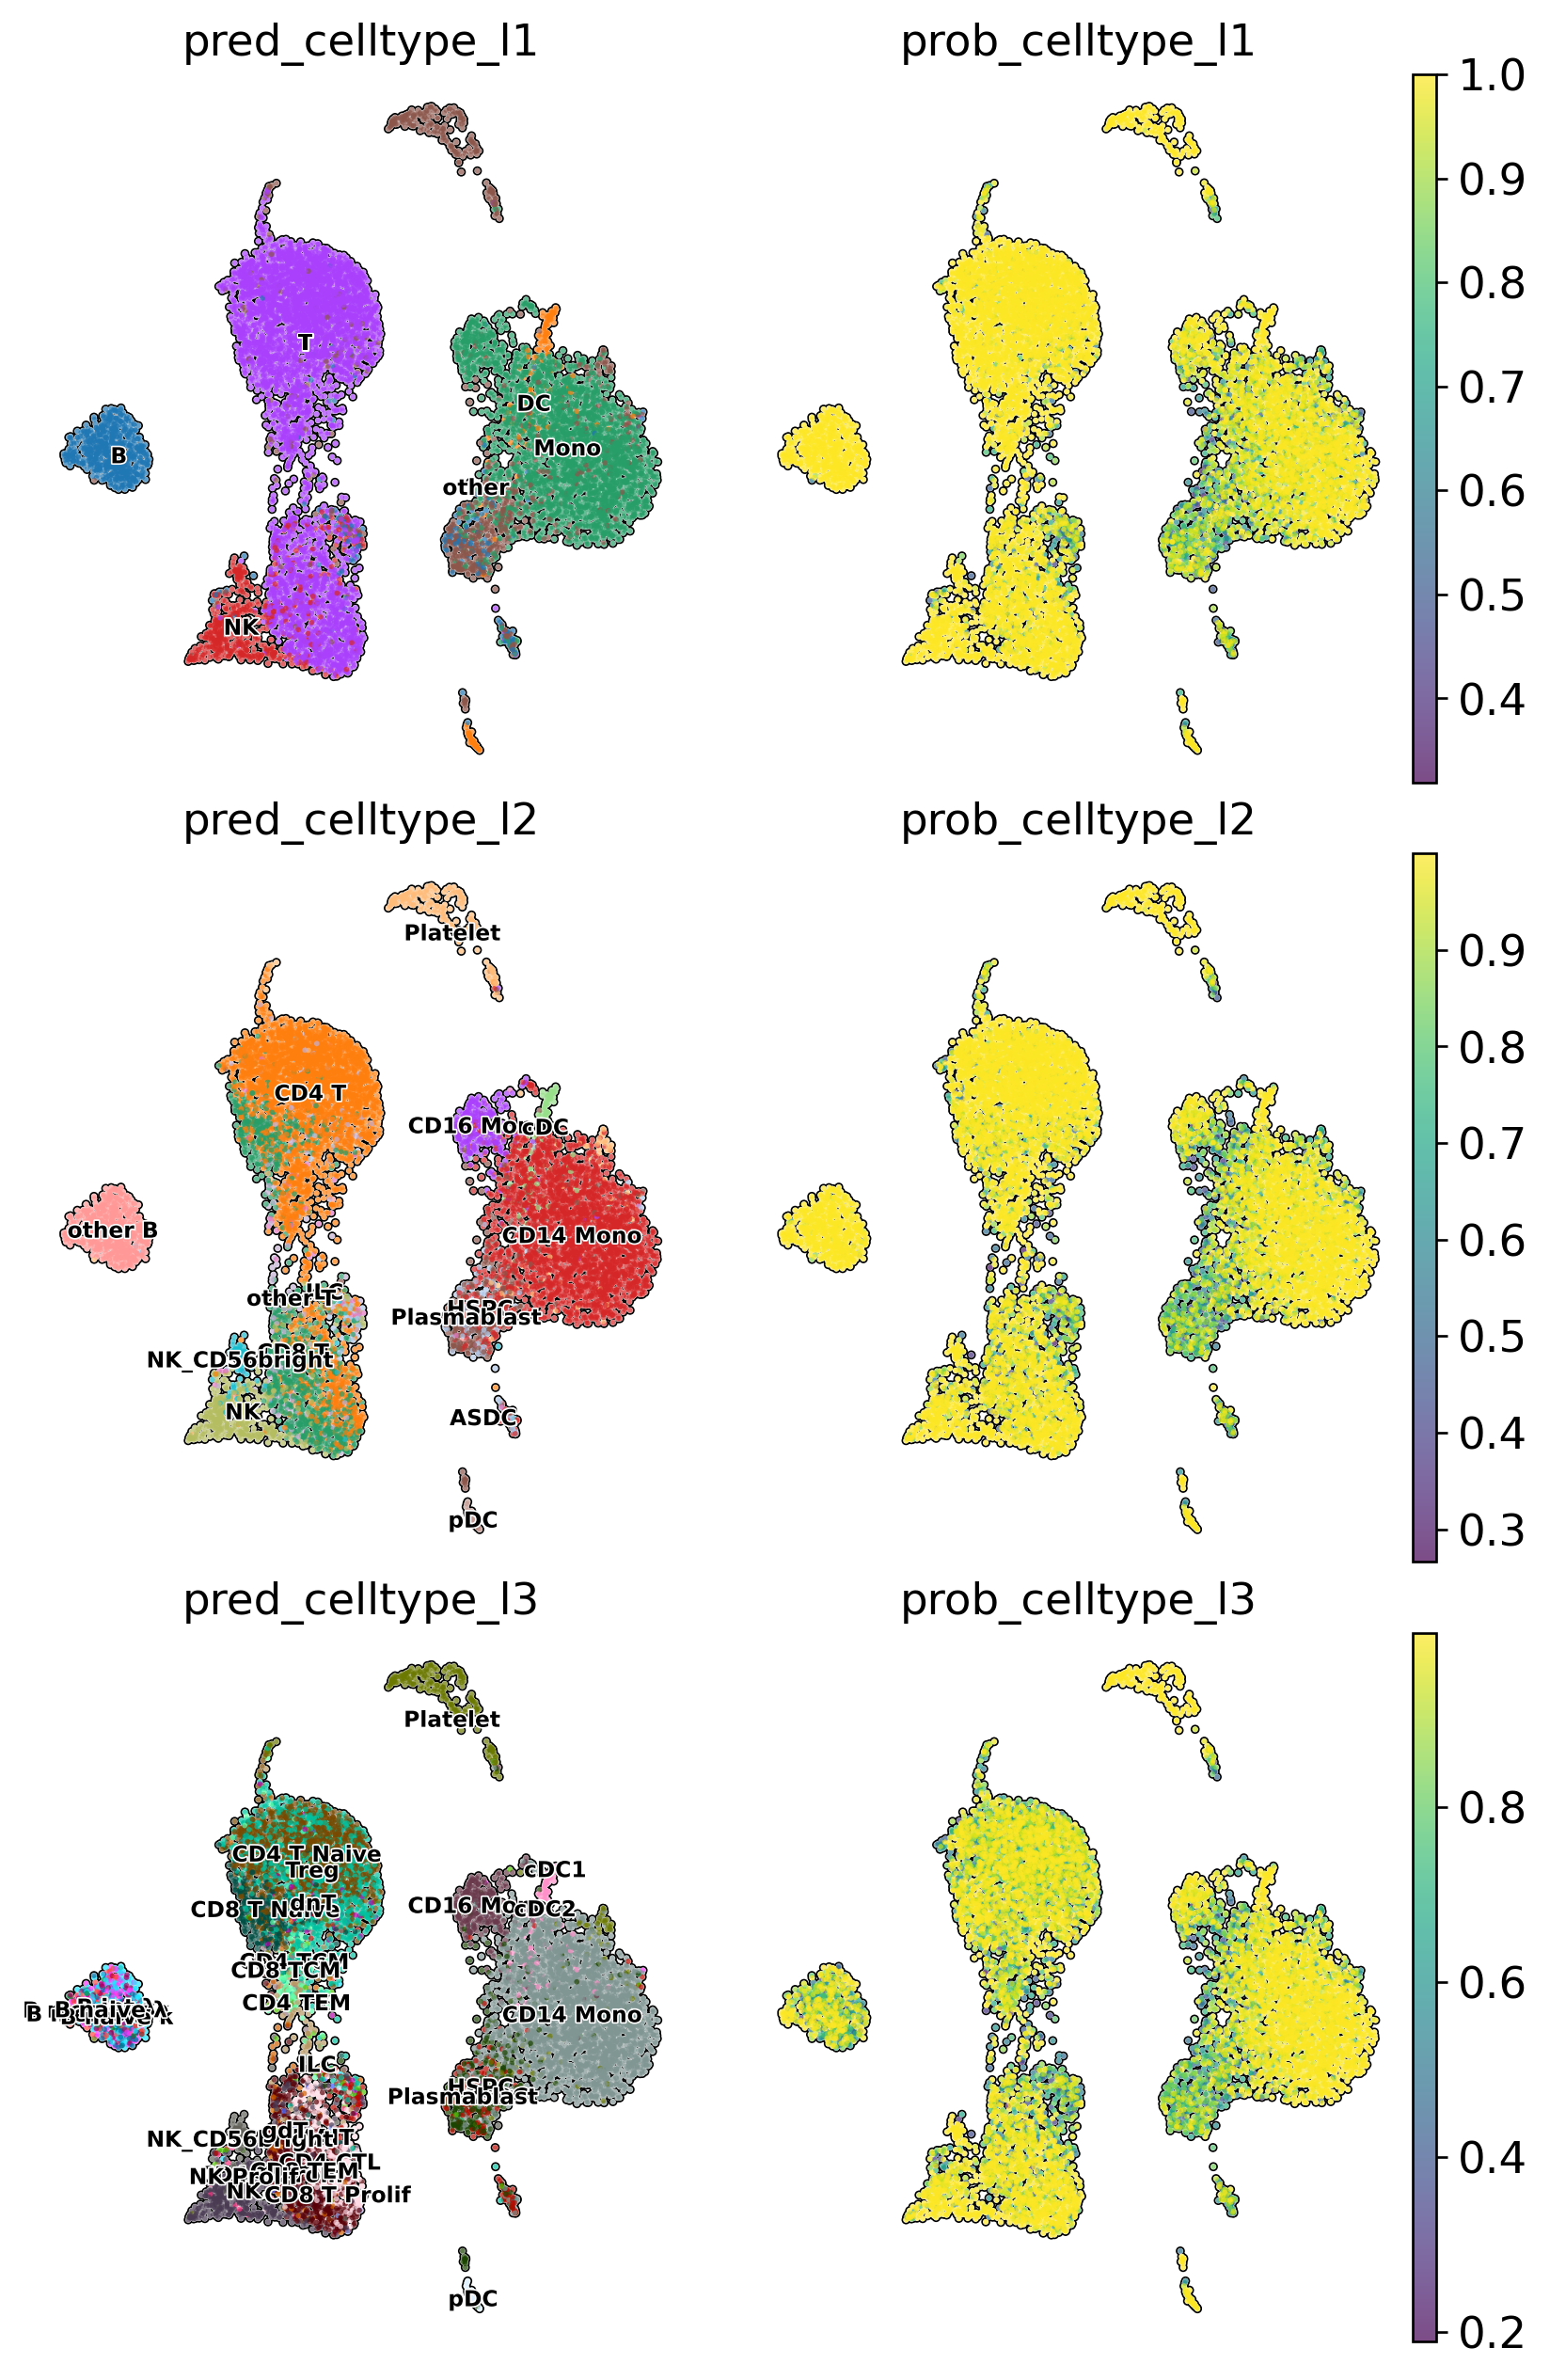

In [ ]:
sc.pl.embedding(adata_2,
                color = [
                    'pred_celltype_l1',
                    'prob_celltype_l1',
                    'pred_celltype_l2',
                    'prob_celltype_l2',
                    'pred_celltype_l3',
                    'prob_celltype_l3'
                ],
                basis = 'X_umap',
                frameon = False,
                add_outline = True,
                legend_loc = 'on data',
                legend_fontsize = 7,
                legend_fontoutline = 1,
                show=False,
                ncols = 2,
                wspace = 0,
                hspace = 0.1)

In [4]:
from glob import glob
files =	[glob('/mnt/cephfs8_rw/functional-genomics/10X_SC_RES/scRNA/cellranger-9.0.1/250820_A01022_0875_BHJ3CCDRX5*/*/outs/metrics_summary.csv')[0] ,
		glob('/mnt/cephfs8_rw/functional-genomics/10X_SC_RES/scATAC/cellranger-atac-2.2.0/250724_VH00195_208_AAG5KNNM5*/*/outs/summary.csv')[0],
        glob('/mnt/cephfs8_rw/functional-genomics/10X_SC_RES/Visium_FFPE/spaceranger-3.1.2/250304_VH00195_195_AAFVF3NM5*/*/outs/metrics_summary.csv')[0] ,
        glob('/mnt/cephfs8_rw/functional-genomics/SG_SC_RES/scRNA/seeksoultools.1.2.2/250902_VH00195_213_AAAJYKLHV*/*/*summary.csv')[0] ,
        glob('/mnt/cephfs8_rw/functional-genomics/SG_SC_RES/flRNA/seeksoultools.1.2.2/250823_VH00195_212_AAATMHHHV*/*/*summary.csv')[0] ,
        glob('/mnt/cephfs8_rw/functional-genomics/SG_SC_RES/scVDJ/seeksoultools.1.2.2/250829_A01007_0874_BHJMC2DRX5*/*/*summary.csv')[0],
        glob('/mnt/cephfs8_rw/functional-genomics/SG_SC_RES/scVDJ/seeksoultools.1.2.2/250829_A01007_0874_BHJMC2DRX5*/*/outs/metrics_summary.csv')[0]]

In [6]:
for file in files:
	df = pd.read_csv(file)
	df.columns	=	[x.lower() for x in df.columns]
	

	seq_type	=	file.split('/')[5]
	tools		=	file.split('/')[4]
	if seq_type == 'scRNA' and tools	==	'10X_SC_RES':
		columns	=	['estimated number of cells', 'mean reads per cell', 'median genes per cell', 'number of reads', 'reads mapped confidently to genome', 'total genes detected']
	elif seq_type == 'scATAC' and tools	==	'10X_SC_RES':
		columns	=	['estimated number of cells','mean raw read pairs per cell', 'median high-quality fragments per cell', 'fraction of high-quality fragments overlapping peaks', 'sequenced read pairs', 'number of peaks']
	elif seq_type == 'Visium_FFPE' and tools	==	'10X_SC_RES':
		columns	=	['number of spots under tissue', 'mean reads per spot', 'median genes per spot', 'number of reads', 'reads mapped confidently to probe set', 'genes detected']

	elif seq_type == 'scRNA' and tools	==	'SG_SC_RES':
		columns	=	['estimated_number_of_cells', 'mean_reads_per_cell', 'median_genes_per_cell', 'number_of_reads', 'reads_mapped_confidently_to_genome', 'total_genes_detected']
	elif seq_type == 'flRNA' and tools	==	'SG_SC_RES':
		columns	=	['estimated_number_of_cells', 'mean_reads_per_cell', 'median_genes_per_cell', 'number_of_reads', 'reads_mapped_confidently_to_genome', 'total_genes_detected']
	elif seq_type == 'scVDJ' and tools	==	'SG_SC_RES' and 'outs' not in file:
		columns	=	['estimated_number_of_cells', 'mean_reads_per_cell', 'median_genes_per_cell', 'number_of_reads', 'reads_mapped_confidently_to_genome', 'total_genes_detected']
	elif seq_type == 'scVDJ' and tools	==	'SG_SC_RES' and 'outs' in file:
		columns	=	['estimated number of cells', 'mean read pairs per cell', 'number of cells with productive v-j spanning pair', 'number of read pairs', 'reads mapped to any v(d)j gene', 'median tra umis per cell', 'median trb umis per cell']

	#df	=	df[columns]
	print(df.columns)
	display(df)

Index(['estimated number of cells', 'mean reads per cell',
       'median genes per cell', 'number of reads', 'valid barcodes',
       'valid umis', 'sequencing saturation', 'q30 bases in barcode',
       'q30 bases in rna read', 'q30 bases in umi', 'reads mapped to genome',
       'reads mapped confidently to genome',
       'reads mapped confidently to intergenic regions',
       'reads mapped confidently to intronic regions',
       'reads mapped confidently to exonic regions',
       'reads mapped confidently to transcriptome',
       'reads mapped antisense to gene', 'fraction reads in cells',
       'total genes detected', 'median umi counts per cell'],
      dtype='object')


,estimated number of cells,mean reads per cell,median genes per cell,number of reads,valid barcodes,valid umis,sequencing saturation,q30 bases in barcode,q30 bases in rna read,q30 bases in umi,reads mapped to genome,reads mapped confidently to genome,reads mapped confidently to intergenic regions,reads mapped confidently to intronic regions,reads mapped confidently to exonic regions,reads mapped confidently to transcriptome,reads mapped antisense to gene,fraction reads in cells,total genes detected,median umi counts per cell
0,"14,437","24,073","1,413","347,546,213",96.7%,100.0%,48.5%,95.0%,92.9%,94.8%,95.3%,91.9%,17.7%,61.7%,12.6%,47.9%,25.9%,71.1%,"23,995","2,504"


Index(['sample id', 'genome', 'pipeline version', 'estimated number of cells',
       'confidently mapped read pairs', 'estimated bulk library complexity',
       'fraction of all fragments in cells',
       'fraction of all fragments that pass all filters and overlap called peaks',
       'fraction of genome in peaks',
       'fraction of high-quality fragments in cells',
       'fraction of high-quality fragments overlapping tss',
       'fraction of high-quality fragments overlapping peaks',
       'fraction of transposition events in peaks in cells',
       'fragments flanking a single nucleosome',
       'fragments in nucleosome-free regions', 'mean raw read pairs per cell',
       'median high-quality fragments per cell', 'non-nuclear read pairs',
       'number of peaks', 'percent duplicates', 'q30 bases in barcode',
       'q30 bases in read 1', 'q30 bases in read 2',
       'q30 bases in sample index i1', 'sequenced read pairs',
       'sequencing saturation', 'tss enrichment 

,sample id,genome,pipeline version,estimated number of cells,confidently mapped read pairs,estimated bulk library complexity,fraction of all fragments in cells,fraction of all fragments that pass all filters and overlap called peaks,fraction of genome in peaks,fraction of high-quality fragments in cells,...,percent duplicates,q30 bases in barcode,q30 bases in read 1,q30 bases in read 2,q30 bases in sample index i1,sequenced read pairs,sequencing saturation,tss enrichment score,unmapped read pairs,valid barcodes
0,770132410401_h,GRCh38,cellranger-atac-2.2.0,5989,0.8535,346878854.0,0.6342,0.0377,0.0203,0.6813,...,0.2854,0.8735,0.9467,0.9364,0.9408,247857272,0.4134,3.5343,0.0082,0.9694


Index(['sample id', 'number of spots under tissue', 'number of reads',
       'mean reads per spot', 'mean reads under tissue per spot',
       'fraction of spots under tissue', 'valid barcodes', 'valid umis',
       'sequencing saturation', 'q30 bases in barcode',
       'q30 bases in probe read', 'q30 bases in umi',
       'reads mapped to probe set', 'reads mapped confidently to probe set',
       'fraction reads in spots under tissue', 'median genes per spot',
       'median umi counts per spot', 'genes detected',
       'reads mapped confidently to the filtered probe set', 'number of genes',
       'number of genes >= 10 umis', 'umis per sq mm of tissue',
       'reads per sq mm of tissue', 'reads half-mapped to probe set',
       'reads split-mapped to probe set'],
      dtype='object')


,sample id,number of spots under tissue,number of reads,mean reads per spot,mean reads under tissue per spot,fraction of spots under tissue,valid barcodes,valid umis,sequencing saturation,q30 bases in barcode,...,median genes per spot,median umi counts per spot,genes detected,reads mapped confidently to the filtered probe set,number of genes,number of genes >= 10 umis,umis per sq mm of tissue,reads per sq mm of tissue,reads half-mapped to probe set,reads split-mapped to probe set
0,770133583401_h,4555,95019351,20860.450274,20105.32843,0.91246,0.985976,0.999942,0.486544,0.964579,...,3425.0,8127.0,16600,0.810608,17943,13423,965246.474321,2.321631e+06,0.009211,0.001634


Index(['samplename', 'estimated_number_of_cells', 'mean_reads_per_cell',
       'median_genes_per_cell', 'number_of_reads', 'valid_barcodes',
       'sequencing_saturation', 'reads_mapped_confidently_to_genome',
       'fraction_reads_in_cells', 'total_genes_detected',
       'median_umi_counts_per_cell'],
      dtype='object')


,samplename,estimated_number_of_cells,mean_reads_per_cell,median_genes_per_cell,number_of_reads,valid_barcodes,sequencing_saturation,reads_mapped_confidently_to_genome,fraction_reads_in_cells,total_genes_detected,median_umi_counts_per_cell
0,962003535201_h,11764,24531,2063,288586087,95.49%,57.51%,85.13%,87.72%,29117,4308


Index(['samplename', 'estimated_number_of_cells', 'mean_reads_per_cell',
       'median_genes_per_cell', 'number_of_reads', 'valid_barcodes',
       'sequencing_saturation', 'reads_mapped_confidently_to_genome',
       'fraction_reads_in_cells', 'total_genes_detected',
       'median_umi_counts_per_cell'],
      dtype='object')


,samplename,estimated_number_of_cells,mean_reads_per_cell,median_genes_per_cell,number_of_reads,valid_barcodes,sequencing_saturation,reads_mapped_confidently_to_genome,fraction_reads_in_cells,total_genes_detected,median_umi_counts_per_cell
0,772120681001_772120581001_770813091001_h,20432,58924,1605,1203949364,93.25%,90.87%,80.63%,94.48%,30093,2801


Index(['samplename', 'estimated_number_of_cells', 'mean_reads_per_cell',
       'median_genes_per_cell', 'number_of_reads', 'valid_barcodes',
       'sequencing_saturation', 'reads_mapped_confidently_to_genome',
       'fraction_reads_in_cells', 'total_genes_detected',
       'median_umi_counts_per_cell'],
      dtype='object')


,samplename,estimated_number_of_cells,mean_reads_per_cell,median_genes_per_cell,number_of_reads,valid_barcodes,sequencing_saturation,reads_mapped_confidently_to_genome,fraction_reads_in_cells,total_genes_detected,median_umi_counts_per_cell
0,963200155201_1_h,10473,103418,2420,1083102916,96.62%,90.50%,89.81%,85.47%,24782,5427


Index(['samplename', 'estimated number of cells', 'mean read pairs per cell',
       'number of cells with productive v-j spanning pair',
       'number of read pairs', 'valid barcodes', 'q30 bases in barcode',
       'q30 bases in rna read', 'q30 bases in umi',
       'reads mapped to any v(d)j gene', 'reads mapped to tra',
       'reads mapped to trb', 'mean used read pairs per cell',
       'fraction reads in cells', 'median tra umis per cell',
       'median trb umis per cell', 'cells with productive v-j spanning pair',
       'cells with productive v-j spanning (tra, trb) pair',
       'paired clonotype diversity', 'cells with productive tra contig',
       'cells with productive trb contig'],
      dtype='object')


,samplename,estimated number of cells,mean read pairs per cell,number of cells with productive v-j spanning pair,number of read pairs,valid barcodes,q30 bases in barcode,q30 bases in rna read,q30 bases in umi,reads mapped to any v(d)j gene,...,reads mapped to trb,mean used read pairs per cell,fraction reads in cells,median tra umis per cell,median trb umis per cell,cells with productive v-j spanning pair,"cells with productive v-j spanning (tra, trb) pair",paired clonotype diversity,cells with productive tra contig,cells with productive trb contig
0,963200155201_2_h,"7,487","7,446","4,050","56,440,259",98.78%,96.76%,94.78%,92.11%,96.58%,...,56.20%,"2,903",50.75%,6,11,54.09%,54.09%,"1,373.67",70.67%,83.21%


In [34]:
df = pd.read_csv(glob('/mnt/cephfs8_rw/functional-genomics/SG_SC_RES/scVDJ/seeksoultools.1.2.2/250829_A01007_0874_BHJMC2DRX5/*/outs/metrics_summary.csv')[0])

In [35]:
[x.lower() for x in df.columns]

['samplename',
 'estimated number of cells',
 'mean read pairs per cell',
 'number of cells with productive v-j spanning pair',
 'number of read pairs',
 'valid barcodes',
 'q30 bases in barcode',
 'q30 bases in rna read',
 'q30 bases in umi',
 'reads mapped to any v(d)j gene',
 'reads mapped to tra',
 'reads mapped to trb',
 'mean used read pairs per cell',
 'fraction reads in cells',
 'median tra umis per cell',
 'median trb umis per cell',
 'cells with productive v-j spanning pair',
 'cells with productive v-j spanning (tra, trb) pair',
 'paired clonotype diversity',
 'cells with productive tra contig',
 'cells with productive trb contig']